# OD calculation
Notebook calculating the optical density and fitting the marginals (non-normalized) to a gaussian distribution.

This notebook includes some pointers on using `scikit-images` for image processing, which could be helpful.

It is important to note that the axes of images are flipped, ordered `[y][x]`.

In [10]:
#Imports

#path tools
from pathlib import Path
import os

#image processing
from skimage.io import imread, imshow
from skimage.measure import label, regionprops
from scipy.ndimage import median_filter

#other utils
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats.contingency import margins #compute marginals
from scipy.optimize import curve_fit
from itertools import product

wd = Path(os.getcwd()) #current working directory
np.seterr(divide='ignore'); #doesn't end up mattering, suppress the annoying warning

In [3]:
example_dir = wd / "test_data" #test data directory

#each image has an accompanying background image with just noise
im0 = imread(example_dir / "img_0.tif")
im0_background = imread(example_dir / "img_2.tif")

#I am unclear on why the second image is necessary
im1 = imread(example_dir / "img_1.tif")
im1_background = imread(example_dir / "img_3.tif")

/tmp/ipykernel_171323/2697091872.py:10: RuntimeWarning: invalid value encountered in divide
  I_div_arr = np.divide(I_arr, I0_arr)


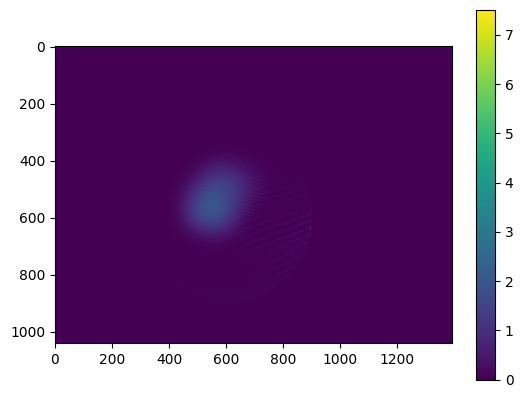

In [4]:
#get background intensity value with noise subtracted
I0_arr=np.subtract(np.array(im0),
                    np.array(im0_background)).astype(int)

#get foreground intensity with noise subtracted
I_arr=np.subtract(np.array(im1),
                    np.array(im1_background)).astype(int)


I_div_arr = np.divide(I_arr, I0_arr)
od_arr = np.log(I_div_arr)

def incircle(center, radius, pt):
    return (pt[0]-center[0])**2 + (pt[1]-center[1])**2 < radius**2

#first pass, just clip anything not within the aperture
for i,row in enumerate(od_arr):
    for j, pixel in enumerate(row):
        if pixel < 0 or not incircle((600,600),300,(i,j)):
            od_arr[i][j] = 0

img1 = plt.imshow(od_arr)
plt.colorbar(img1)

## Create image mask
A couple parameters can be used to mask out the unwanted data. First, `lower_mask` and `upper_mask` are just rough cutoff values. The `value_mask` parameter tries to get as much of the blob as possible while cutting off the noise. This can be set low, because the median mask will eliminate the outliers.

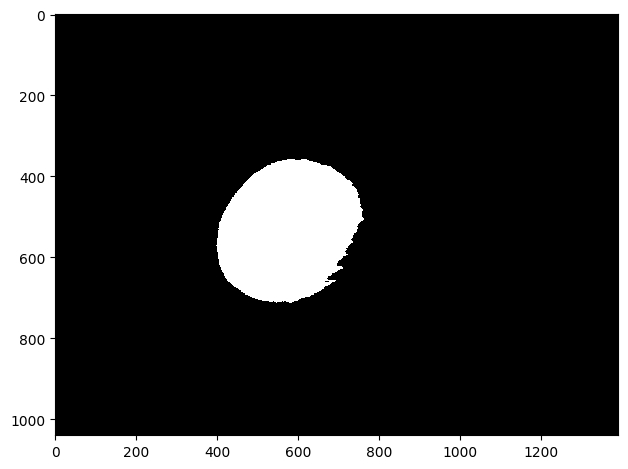

In [5]:
lower_mask = od_arr[:,:] > 0
upper_mask = od_arr[:,:] < 5
value_mask = od_arr[:,:] > .05
mask = lower_mask*upper_mask*value_mask

mask_filtered = median_filter(lower_mask*upper_mask*value_mask, 20)
imshow(mask_filtered)

## Get blob bounding box
THe `label` function is used to separate contiguous regions of the image and returns useful properties regarding their shape, location, and orientation.

In [6]:
blobs = label(mask_filtered)
props = regionprops(blobs) #generate a properties dictionary
bbox = props[0].bbox #get the bounding box
bbox 

(357, 398, 715, 762)

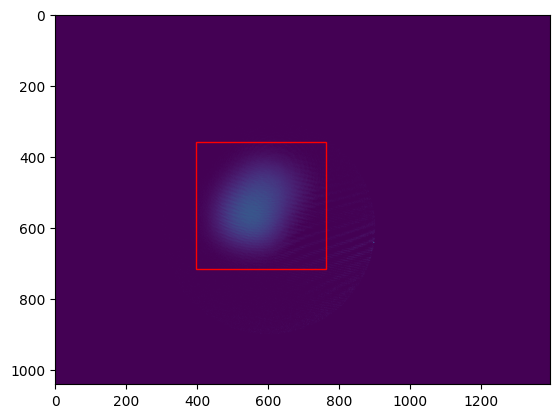

In [7]:
#draw bounding box
fig, ax = plt.subplots()
rect = plt.Rectangle((bbox[1],bbox[0]),bbox[3]-bbox[1], bbox[2]-bbox[0])
rect.set(fill=False, color = "red")
ax.add_artist(rect)
ax.imshow(od_arr)

In [8]:
#extract blob rectangle from image
blob_arr = od_arr[bbox[0]:bbox[2], bbox[1]:bbox[3]]
#apply a median filter
blob_arr = median_filter(blob_arr, 3)

In [13]:
#compute marginals and fit to a gaussian
x, y = margins(blob_arr)
x = x.T[0]
y = y[0]

mu1 = np.sum([i*xi for i,xi in enumerate(x)])/np.sum(x)
mu2 = np.sum([i*xi for i,xi in enumerate(x)])/np.sum(x)

def bivariate_gaussian(X, A, sigma1, sigma2, rho):
    def z():
        return (X[0]-mu1)**2/sigma1**2-2*rho*(X[0]-mu1)*(X[1]-mu2)/(sigma1*sigma2)+(X[1]-mu2)**2/sigma2**2
    
    return np.exp(-z()/(2*(1-rho**2)))


popt, pcov = curve_fit(bivariate_gaussian, np.array(list(product(range(len(x)), range(len(y))))).T, blob_arr.flatten(), p0 =[350, 60, 60, 0])

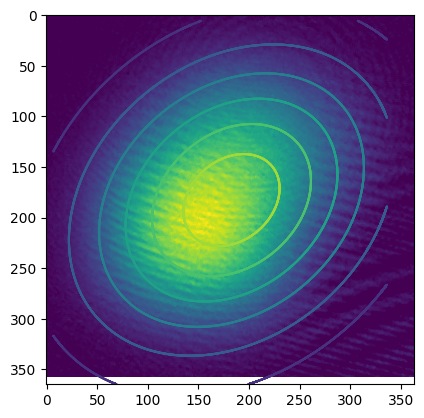

In [14]:
plt.imshow(blob_arr)
plt.contour(x, y.T, [[bivariate_gaussian((x,y),*popt) for x in x] for y in y.T])